In [1]:
!pip install adlfs
!pip install keras-tuner --quiet


#### IMPORTS

In [1]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import plotly.express as px
import joblib
from datetime import timedelta
from typing import List, Tuple, Dict,Optional
import os
import joblib
from tensorflow.keras.models import save_model

# Azure
from adlfs import AzureBlobFileSystem

from typing import Tuple, List, Optional
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import pandas as pd


# Models
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc ,  precision_score, recall_score
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.utils import class_weight

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU,Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, Precision, Recall
from keras_tuner import RandomSearch

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


2025-06-24 11:02:57.160269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-24 11:02:57.303808: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 11:02:57.308127: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-24 11:02:57.308148: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:

def load_data_from_dl(account_name: str,container_name: str,relative_path: str,access_key: str)->pd.DataFrame:
    """
    Loads all Parquet files from an Azure Blob Storage path into a single DataFrame.
    Args:
        - account_name (str): Azure Storage account name.
        - container_name (str): Name of the container.
        - relative_path (str): Path inside the container to search for .parquet files.
        - access_key (str): Storage account access key.
    Returns:
        - df (pd.DataFrame): Combined DataFrame from all found Parquet files.
    Raises:
        - ValueError: If no Parquet files are found in the path.
    """
    abfs = AzureBlobFileSystem(account_name=account_name, account_key=access_key)


    all_files = abfs.glob(f"{container_name}/{relative_path}/*.parquet")
    print(f"folder: {all_files}")

    if not all_files:
        raise ValueError("Not found .parquet files")

    dfs = []
    for f in all_files:
        print(f"Reading files: {f}")
        with abfs.open(f, "rb") as fp:
            dfs.append(pd.read_parquet(fp))

    df = pd.concat(dfs, ignore_index=True)
    print(df.head())
    return df

In [3]:
def model_evaluation(
    y_test: pd.Series,
    y_pred: pd.Series,
    y_prob: pd.Series
) -> Tuple[float, float, float, np.ndarray, float, float]:
    """
    Evaluates the classification model and plots metrics.

    Args:
        y_test (pd.Series): True target values.
        y_pred (pd.Series): Predicted class values.
        y_prob (pd.Series): Predicted probabilities for class 1.

    Returns:
        Tuple containing Accuracy, F1 Score, ROC AUC, Confusion Matrix, Precision, Recall.
    """
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No', 'Yes'])
    ax.set_yticklabels(['No', 'Yes'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return acc, f1, roc, cm, precision, recall


In [4]:
def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
  """
  Cleans a DataFrame by dropping unnecessary columns and handling missing values.

  Args:
      df (pd.DataFrame): Input DataFrame.

  Returns:
      pd.DataFrame: Cleaned DataFrame.
  """
  columns_to_drop = [
      'capital_gains',
      'ret_next_3m', 'ret_next_6m', 'ret_next_1y',
      'price_lead_3m', 'price_lead_6m', 'price_lead_1y',
      'open_v', 'high', 'low', 'dividends', 'stock_splits',
      'is_dividend_day', 'is_stock_split', 'gap_open', 'price_range',
      'tr_1', 'tr_2', 'tr_3', 'sma_5', 'bollinger_upper',
      'bollinger_lower', 'ema_12', 'macd_line'
  ]


  df = df.drop(columns=columns_to_drop, errors='ignore').copy()
  numeric_cols = df.select_dtypes(include=["float64", "int64", "int32"]).columns
  imputer = SimpleImputer(strategy="mean")
  df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
  return df;

In [5]:
def prepare_data_with_symbol_date(df: pd.DataFrame, targets: list):
    """
    Prepares a DataFrame for LSTM modeling: encodes 'symbol', extracts 'date' features,
    imputes missing values, and applies MinMax scaling.

    Args:
        df (pd.DataFrame): Input data with features + target + symbol + date.
        targets (list): List of target column names.

    Returns:
        pd.DataFrame: Scaled dataframe with 'symbol' and 'date' incorporated as features.
        MinMaxScaler: The fitted scaler object.
    """
    df_clean = df.copy()

    # Convert date and extract features
    df_clean["date"] = pd.to_datetime(df_clean["date"], errors="coerce")
    df_clean["year"] = df_clean["date"].dt.year
    df_clean["month"] = df_clean["date"].dt.month
    df_clean["dayofweek"] = df_clean["date"].dt.dayofweek

    date_col = df_clean["date"]  # store datetime (not string)

    # Encode symbol (remains numeric)
    df_clean["symbol"] = LabelEncoder().fit_transform(df_clean["symbol"].astype(str))

    # Drop original date before scaling
    df_clean = df_clean.drop(columns=["date"], errors="ignore")

    for col in df_clean.select_dtypes(include=["object", "category"]).columns:
        df_clean[col] = LabelEncoder().fit_transform(df_clean[col].astype(str))

    feature_cols = [col for col in df_clean.columns if col not in targets]
    X = df_clean[feature_cols]
    y = df_clean[targets]

    imputer = SimpleImputer(strategy="mean")
    X_imputed = imputer.fit_transform(X)
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    df_scaled = pd.DataFrame(X_scaled, columns=feature_cols, index=df_clean.index)
    df_scaled = pd.concat([df_scaled, y], axis=1)

    # Reattach encoded symbol and original date
    df_scaled["symbol"] = df_clean["symbol"].values
    df_scaled["date"] = date_col.values

    print(f"columnas scaler: {X.columns}")
    return df_scaled, scaler


In [6]:
def train_improved_lstm_classifier(
    X_train,
    X_test,
    y_train,
    y_test,
    sequence_length=120,
    epochs=30,
    batch_size=32,
    patience=6,
    learning_rate=1e-4,
    threshold=0.5,
    class_weight=None
):
    """
    Trains a bidirectional LSTM classifier with dropout, batch normalization, and threshold tuning.

    Args:
        X_train, X_test: Input sequences
        y_train, y_test: Labels
        sequence_length (int): Number of timesteps per sequence
        epochs (int): Max epochs
        batch_size (int): Training batch size
        patience (int): Early stopping patience
        learning_rate (float): Optimizer learning rate
        threshold (float): Threshold to binarize output
        class_weight (dict): Optional class weights

    Returns:
        model: Trained Keras model
        X_test, y_test: Evaluation inputs
        y_prob: Predicted probabilities
        y_pred: Binary predictions based on threshold
    """
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
        BatchNormalization(),
        Dropout(0.4),
        Bidirectional(LSTM(32, return_sequences=False)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(),
        metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
    )

    early_stop = EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=patience,
        restore_best_weights=True
    )

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1,
        class_weight=class_weight
    )

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > threshold).astype(int)

    return model, X_test, y_test, y_prob, y_pred


In [7]:
def save_trained_model_and_scaler(model, scaler, feature_cols, model_name, target_column, folder_path='pkls'):
    """
    Saves the trained LSTM model, fitted scaler, and feature column list to disk.

    Args:
        model: Trained Keras model to be saved.
        scaler: Fitted MinMaxScaler object used during preprocessing.
        feature_cols (list): List of feature column names used for training.
        model_name (str): Name identifier for the model (used in filenames).
        target_column (str): Target column the model was trained to predict.
        folder_path (str): Directory path to save model, scaler, and feature list (default is 'pkls').

    Returns:
        None
    """
    os.makedirs(folder_path, exist_ok=True)
    save_model(model, os.path.join(folder_path, f"{model_name}.keras"))
    joblib.dump(scaler, os.path.join(folder_path, f"scaler_{model_name}.pkl"))
    joblib.dump(feature_cols, os.path.join(folder_path, f"features_{model_name}.pkl"))
    print(f"model saved in : {model_name}.keras")
    print(f"Scaler saved in: scaler_{model_name}.pkl")
    print(f"Features saved in: features_{model_name}.pkl")

In [8]:
import sys
def build_and_split_sequences_by_symbol(
    df: pd.DataFrame,
    target_column: str,
    sequence_length: int = 60,
    test_size: float = 0.2
):
    """
    Builds sequential data for each symbol independently and performs temporal train-test split.

    Args:
        df (pd.DataFrame): Preprocessed DataFrame with features, target, 'symbol' and 'date'.
        target_column (str): Column name for binary target.
        sequence_length (int): Time window for each sequence.
        test_size (float): Proportion of test samples (applied per symbol).

    Returns:
        Tuple of numpy arrays: X_train, X_test, y_train, y_test
    """
    X_train, y_train, X_test, y_test = [], [], [], []

    symbols = df["symbol"].unique()
    for symbol in symbols:
        df_symbol = df[df["symbol"] == symbol].copy()
        df_symbol = df_symbol.sort_values("date")

        if len(df_symbol) <= sequence_length:
            continue  # Skip if not enough data

        df_symbol[target_column] = df_symbol[target_column].astype(int)
        features = df_symbol.drop(
            columns=["date", "target_3m", "target_6m", "target_1y"],
            errors="ignore"
        )

        target = df_symbol[target_column].values

        split_idx = int(len(features) * (1 - test_size))
        for i in range(len(features) - sequence_length):
            if i + sequence_length >= len(features):
                continue

            X_seq = features.iloc[i:i + sequence_length].values.astype(np.float32)
            y_val = target[i + sequence_length]

            if i + sequence_length < split_idx:
                X_train.append(X_seq)
                y_train.append(y_val)
            else:
                X_test.append(X_seq)
                y_test.append(y_val)

    return (
        np.array(X_train),
        np.array(X_test),
        np.array(y_train),
        np.array(y_test)
    )


#### FUNCTIONS

In [9]:
with open("config.yaml", "r") as file:
    config = yaml.safe_load(file)

account_name = config['storage']['storage_account_name']
container_name = config['storage']['container_name']
relative_path = config['storage']['relative_path']
access_key = config['storage']['access_key']
# Cargar el DataFrame desde Azure
df_full = load_data_from_dl(account_name, container_name, relative_path, access_key)


folder: ['smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet']
Reading files: smart-wallet-dl/smart_wallet/stock_data_parquet/part-00000-tid-6319656906602864551-70988dce-8c71-437f-9993-81d0d24559f8-53-1-c000.snappy.parquet
         date  symbol      open_v        high         low     close_v  \
0  2023-07-25  TEL.OL   99.110617   99.423126   98.128441   98.128441   
1  2023-07-25    ACIW   23.270000   23.530001   23.129999   23.420000   
2  2023-07-25     TER  114.730270  117.172184  114.730270  116.368141   
3  2023-07-25    ADCT    1.320000    1.330000    1.218000    1.290000   
4  2023-07-25     TEX   59.353587   59.490459   57.574251   57.769783   

      volume  dividends  stock_splits  capital_gains  ...  candle_color  \
0  1170518.0        0.0           0.0            NaN  ...           red   
1   301500.0        0.0           0.0            NaN  ...         green   
2  1256700.0       

columnas scaler: Index(['symbol', 'close_v', 'volume', 'prev_close', 'prev_volume',
       'daily_return', 'close_change_pct', 'intraday_volatility', 'log_return',
       'volume_change_pct', 'sma_20', 'delta', 'gain', 'loss', 'rsi_14',
       'rel_volume', 'ema_26', 'macd_signal', 'macd_histogram', 'true_range',
       'atr_14', 'candle_body', 'upper_wick', 'lower_wick', 'candle_color',
       'momentum_10', 'roc_10', 'var_95', 'year', 'month', 'dayofweek'],
      dtype='object')
Epoch 1/30
8043/8043 [==============================] - 714s 88ms/step - loss: 0.7300 - accuracy: 0.5064 - auc: 0.5086 - precision: 0.4826 - recall: 0.5060 - val_loss: 0.6967 - val_accuracy: 0.5218 - val_auc: 0.4959 - val_precision: 0.5141 - val_recall: 0.4435
Epoch 2/30
8043/8043 [==============================] - 707s 88ms/step - loss: 0.6968 - accuracy: 0.5107 - auc: 0.5181 - precision: 0.4871 - recall: 0.5181 - val_loss: 0.6957 - val_accuracy: 0.4960 - val_auc: 0.4974 

2025-06-24 11:04:25.358901: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-24 11:04:25.358965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jorgegarciaotero1): /proc/driver/nvidia/version does not exist
2025-06-24 11:04:25.360018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


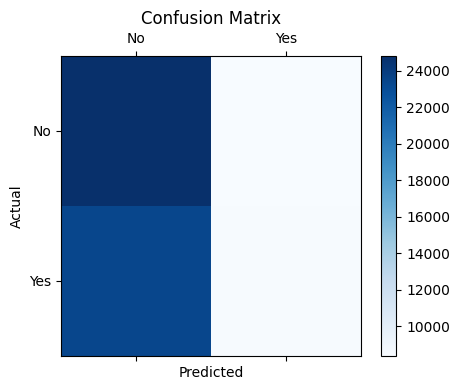

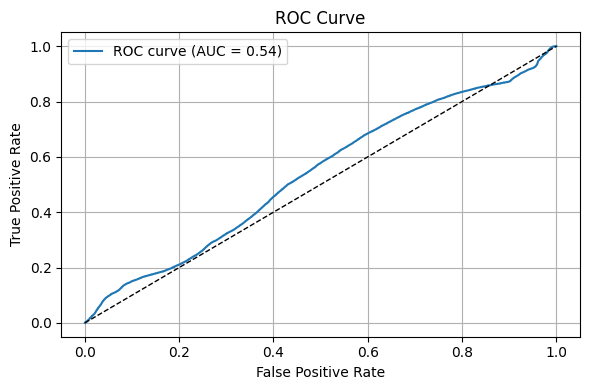

(0.5117996591380184,
 0.3487895793224921,
 0.5385964327392301,
 array([[24818,  8391],
        [23405,  8515]]),
 0.5036673370401041,
 0.2667606516290727)

In [10]:
df_full["target_3m"] = (df_full["ret_next_3m"] > 0.05).astype(int)
df_full["target_6m"] = (df_full["ret_next_6m"] > 0.05).astype(int)
df_full["target_1y"] = (df_full["ret_next_1y"] > 0.05).astype(int)
# Selección de top 50 símbolos con más histórico
top_symbols = (
    df_full.groupby("symbol")
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)
df_clean = df_full[df_full["symbol"].isin(top_symbols)].copy()
df_clean = df_clean.sort_values(by=["symbol", "date"])
#df_clean.to_csv("1_df_clean_ordenado.csv",sep=";")


# Limpieza con imputación
df_clean = clean_columns(df_clean)

# Preprocesado (sin imputar aquí)
targets = ['target_3m', 'target_6m', 'target_1y']
df_processed_minmax, scaler_minmax = prepare_data_with_symbol_date(
    df_clean,
    targets=targets
)


# Secuenciado correcto por símbolo
target_column = 'target_6m'
sequence_length = 60
X_train, X_test, y_train, y_test = build_and_split_sequences_by_symbol(
    df_processed_minmax,
    target_column=target_column,
    sequence_length=sequence_length,
    test_size=0.2
)

# Pesos balanceados
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train.flatten()
)
weight_dict = {0: weights[0], 1: weights[1]}

# Entrenamiento
model, X_test, y_test, y_prob, y_pred = train_improved_lstm_classifier(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    sequence_length=sequence_length,
    class_weight=weight_dict
)

# Evaluación
model_evaluation(
    y_test=pd.Series(y_test),
    y_pred=pd.Series(y_pred),
    y_prob=pd.Series(y_prob)
)


In [11]:
feature_cols = df_clean.columns
feature_cols = [col for col in feature_cols if not col.startswith("target_")]
print(len(feature_cols))
model_name = "improved_lstm"
save_trained_model_and_scaler(model, scaler_minmax, feature_cols, model_name, "target_6m")


29
model saved in : improved_lstm.keras
Scaler saved in: scaler_improved_lstm.pkl
Features saved in: features_improved_lstm.pkl
